# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Chun-Hung Yeh, Kuan Tung, Zhuoyue Wang

**Group:** 5

**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

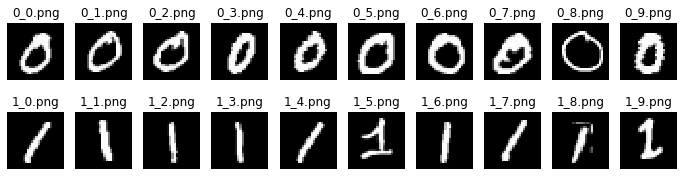

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
# Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [3]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import measure, transform

def fourier(img, components):
    # convert original image to binary image
    img_bin = (img > 0) * 255
    img_bin = img_bin.astype(np.uint8)

    # find contour in an image
    contour = measure.find_contours(img, 0)[0]
    
    # perform Fourier Transform on the corresponding complex number
    uk = contour[:, 1] + 1j*contour[:, 0]
    uk_fft = np.fft.fft(uk)
    
    # choose the first fourier as the reference for normalization
    a0 = abs(uk_fft[1])
    
    return [abs(uk_fft[i])/a0 for i in components] 


def img_rotate(img):
    # return rotated images
    trans90  =  [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in img]
    trans180 = [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in img]
    trans270 = [transform.rotate(i, 270, resize=False, preserve_range=True).astype('uint8') for i in img]
    return  list(img) + trans90 + trans180 +trans270


def morphology(img):
    img = ndimage.grey_opening(img, size = (1,2))    
    ret, thres = cv2.threshold(img, 45, 255, cv2.THRESH_BINARY)
    contour = measure.find_contours(thres, 0)[0]
    return thres


def fourier_trans(img, components):
    img_aug = img_rotate(img)
    img_fourier = []
    for img in img_aug:
        img = morphology(img)
        a = fourier(img, components)
        img_fourier.append(a)
    img_fourier = np.array(img_fourier)
    return img_fourier

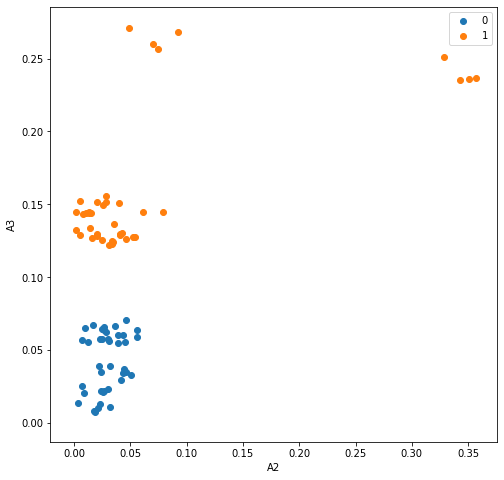

In [4]:
# perform Fourier descriptors from original images
zeros_fourier = fourier_trans(zeros_im, [2,3])
ones_fourier = fourier_trans(ones_im, [2,3])

# visualize
plt.figure(figsize=(8,8))
plt.scatter(zeros_fourier[:,0], zeros_fourier[:,1], label='0')
plt.scatter(ones_fourier[:,0], ones_fourier[:,1], label='1')
plt.xlabel('A2')
plt.ylabel('A3')
plt.legend();

From the figure above, we can obviouly see that there are two clusters, which are 0 and 1 respectively. Also, the two clusters separately have small intra-class variance and large inter-class variance by using only two features of fourier descriptor. Though the in-cluster variance of class 1 is much larger, we could see that this results from 3 far-away clusters composed inside the whole class 1 cluster. 

### 1.3 Additional method(s)
Add your implementation and discussion

#### Method 1: Distance map using Chamfer distance (Contour based)
In this section we would like to try the contour-based method using distance maps and Chamfer distance. First, we select two images from 0 and 1 as references. And then we obtain their distance maps by defining the skeletons and applying the function `distance_map`. So the other images of 0 and 1 are subsequently compared with these distance maps and measured their similarity, taking rotation and translation invariance into account.

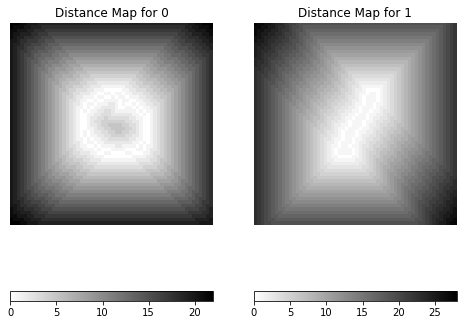

In [5]:
def distance_map(img_num):
    # build a distance map on img_num (0 or 1)
    img = np.ones((img_num.shape[0], img_num.shape[1]))
    contour, _ = cv2.findContours(img_num, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton = cv2.drawContours(img, contour, -1, (255, 255, 255), 1)
    skeleton = np.where(skeleton == 255, 0, 1)
    skeleton = np.pad(skeleton, (15, 15), 'edge')
    distance_map_num = ndimage.morphology.distance_transform_cdt(skeleton)
    return distance_map_num

# distance map for 0 and 1
distance_map_zero = distance_map(zeros_im[8, :, :])
distance_map_one = distance_map(ones_im[8,:,:])

# visualize
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.imshow(distance_map_zero, cmap = 'binary')
plt.title('Distance Map for 0')
plt.colorbar(orientation='horizontal')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(distance_map_one, cmap = 'binary')
plt.title('Distance Map for 1')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

Now, let's calculate the similarity of the other images comparing with the references above. We try to find the optimal transformation of the images minimizing the distance with respect to both references. In the end, the min distance will be the feature used to classify the images.

In [6]:
def similarity(img1, img2, prev_distance, angle, i, j):
    # compute the similarity between img1 and img 2
    distance = np.sum(img1*img2)
    if distance < prev_distance:
        return distance, angle, i, j
    else: 
        return None
    
def find_optimal_trans(distance_map_num, shift_x, shift_y, skeleton, m):
    # search the optimal transformation for the template (0 or 1) to the given images
    prev_distance = np.sum(distance_map_num.ravel()) 
    
    # translation and rotation
    for i in range(0, distance_map_num.shape[0] - shift_x):
        for j in range(0, distance_map_num.shape[1] - shift_y):
            for angle in np.arange(0, 360, 10):
                img_rot = skimage.transform.rotate((skeleton.astype('float')), angle, resize = True)
                img_rot = np.where(img_rot >= np.mean(img_rot), 1, 0)
                if (img_rot.shape > skeleton.shape) & ((i+img_rot.shape[0] <= distance_map_num.shape[0]) & (j+img_rot.shape[1] <= distance_map_num.shape[1])):
                    if similarity(img_rot, distance_map_num[i:i+img_rot.shape[0], j:j+img_rot.shape[1]], prev_distance, angle, i, j) != None:
                        min_distance, min_angle, min_trasl_x, min_trasl_y = similarity(img_rot, distance_map_num[i:i+img_rot.shape[0], j:j+img_rot.shape[1]], prev_distance, angle, i, j)
                        prev_distance = min_distance
                elif (img_rot.shape == skeleton.shape):
                    if (similarity(img_rot, distance_map_num[i:i+shift_x, j:j+shift_y], prev_distance, angle, i, j) != None): 
                        min_distance, min_angle, min_trasl_x, min_trasl_y = similarity(img_rot, distance_map_num[i:i+shift_x, j:j+shift_y], prev_distance, angle, i, j)
                        prev_distance = min_distance
    print('Angle:{} and translation:[{},{}] => min_distance:{}'.format(min_angle, min_trasl_x, min_trasl_y, prev_distance))            
    return min_distance

In [7]:
import pandas as pd
from skimage.measure import regionprops

features = pd.DataFrame(index = np.arange(0, len(zeros_im)+len(ones_im)), columns = ['Feature 1','Feature 2'])
image = np.ones((zeros_im[8, :, :].shape[0], zeros_im[8, :, :].shape[1]))

# all zero images:
for m in range(len(zeros_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv2.findContours(zeros_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton = cv2.drawContours(image-1, contour, -1, (255, 255, 255), 1)
    skeleton = np.where(skeleton == 255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(0) For Feature 1 on image0_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_zero, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], m)
    features.iloc[m, 0] = min_distance
    print('\n(0) For Feature 2 on image0_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_one, shift_x, shift_y, skeleton[minr:maxr, minc:maxc], m)
    features.iloc[m, 1] = min_distance
    image = np.ones((zeros_im[8, :, :].shape[0], zeros_im[8, :, :].shape[1]))
    

# all one images
image = np.ones((ones_im[8, :, :].shape[0], ones_im[8, :, :].shape[1]))
for n in range(len(ones_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv2.findContours(ones_im[n,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton = cv2.drawContours(image-1, contour, -1, (255,255,255), 1)
    skeleton = np.where(skeleton==255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(1) For Feature 1 on image1_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_zero, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features.iloc[m+n+1, 0] = min_distance
    print('\n(1) For Feature 2 on image1_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_one, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features.iloc[m+n+1, 1] = min_distance
    image=np.ones((ones_im[8, :, :].shape[0], ones_im[8, :, :].shape[1]))

For Feautre 0 on image00
Angle:180 and translation:[19,20] => min_distance:104
For Feature 1 on image00
Angle:0 and translation:[19,21] => min_distance:132
For Feautre 0 on image01
Angle:0 and translation:[20,23] => min_distance:111
For Feature 1 on image01
Angle:0 and translation:[19,21] => min_distance:171
For Feautre 0 on image02
Angle:0 and translation:[18,19] => min_distance:124
For Feature 1 on image02
Angle:0 and translation:[19,20] => min_distance:181
For Feautre 0 on image03
Angle:180 and translation:[18,20] => min_distance:118
For Feature 1 on image03
Angle:180 and translation:[19,23] => min_distance:111
For Feautre 0 on image04
Angle:180 and translation:[18,20] => min_distance:111
For Feature 1 on image04
Angle:180 and translation:[19,21] => min_distance:124
For Feautre 0 on image05
Angle:0 and translation:[19,20] => min_distance:111
For Feature 1 on image05
Angle:0 and translation:[19,19] => min_distance:227
For Feautre 0 on image06
Angle:0 and translation:[19,22] => min_di

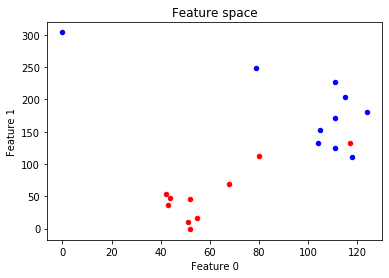

In [8]:
ax = features.iloc[0:len(zeros_im), :].plot.scatter(x = 'Feature 1', y = 'Feature 2', c = 'Blue')
features.iloc[len(zeros_im)::, :].plot.scatter(x = 'Feature 1', y = 'Feature 2', c = 'Red', ax = ax)
plt.title('Feature Space')
plt.show()

From our result, two clusters are able to be classified, though one point in red may be misclassified. After several trials, this method is prone to the references we choose, implying that it's hard to find appropriate images as the references. In addition, here we only consider the rotation and translation invariance since it's difficult to resize images in our implentation. 

#### Method 2: Chain code using edition distance (Contour based)
We also try out another contour-based method using chain codes and edit distances. First, we transform each image into a series of codes by the function `chain_rule`. Then, compute the edit distance between two codes, reflecting minimum number of elementary operations necessary to transform one to the other. To finalize our result, here we choose the compacity and edit distance as our features for classification.

In [9]:
def chain_rule(img):
    # transform img to a chain code
    _, img = cv2.threshold(img, 70, 255, 0)
    
    # find the first pixel on the boundary of the object 
    for i, row in enumerate(img):
        for j, value in enumerate(row):
            if value == 255:
                start_point = (i, j)
                break
                
    directions = [0, 1, 2, 7, 3, 6, 5, 4]
    dir2idx = dict(zip(directions, range(len(directions))))
    change_j = [-1,  0,  1, # change in x
                -1,      1,
                -1,  0,  1]

    change_i = [-1, -1, -1, # change in y
                 0,      0,
                 1,  1,  1]

    border = []
    chain = []
    string = str()

    # chain code: find the first point
    curr_point = start_point
    
    # for direction in directions:
    for direction in range(8):
        idx = dir2idx[direction]
        new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
        if img[new_point] != 0:
            border.append(new_point)
            chain.append(direction)
            string = str(direction)
            curr_point = new_point
            break

    count = 0
    
    # while the coordinates of the current pixel are not equal to those of the starting pixel
    while curr_point != start_point:
        # figure direction to start search
        # the aim of (direction + 5) % 8 is to find the pairs:0-4; 1-5; 2-6; 3-7
        # For example: assume that direction of start point to the first point is 0. 
        # Therefore the direction of the first point to start point is 4, 
        # we need start search from 5-8 and then 0-4
        b_direction = (direction + 5) % 8 
        dirs_1 = range(b_direction, 8)
        dirs_2 = range(0, b_direction)
        dirs = []
        dirs.extend(dirs_1)
        dirs.extend(dirs_2)
        for direction in dirs:
            idx = dir2idx[direction]
            new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
            if img[new_point] != 0: 
                border.append(new_point)
                chain.append(direction)
                string += str(direction)
                curr_point = new_point
                break
        if count == 1000: break
        count += 1
    return string


def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 
            deletions = current_row[j] + 1     
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
        
    return previous_row[-1]


def morphology2(img, sizes, threshold):
    _, thres = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    img = ndimage.grey_closing(thres, size = sizes)
    return img


def edit_distance(img, reference_im, function):
    img_distance = []
    
    # morphology of the reference image
    _, thresh = cv2.threshold(reference_im, 45, 255, cv2.THRESH_BINARY)
    reference_im = ndimage.grey_opening(thresh, size = (2,2))
    comparison = chain_rule(reference_im)
    
    # calculate the edit distance for each contour after rotation 
    for i in img:
        dist_list = []
        _, thresh2 = cv2.threshold(i, 45, 255, cv2.THRESH_BINARY)
        i = ndimage.grey_opening(thresh2, size = (2, 2))
        
        # rotation
        for j in range(10, 360, 10):
            try:
                img_rotated = transform.rotate(i, j, preserve_range = True)
                img_string = chain_rule(img_rotated)
                distance = levenshtein(img_string, comparison)
                dist_list.append([distance])
            except:
                continue
        parameter = function(i)
        img_distance.append([parameter, np.min(dist_list)])
    return np.array(img_distance)


def compacity(img):
    contour, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(contour[0])
    length = cv2.arcLength(contour[0], True)
    return length**2/area

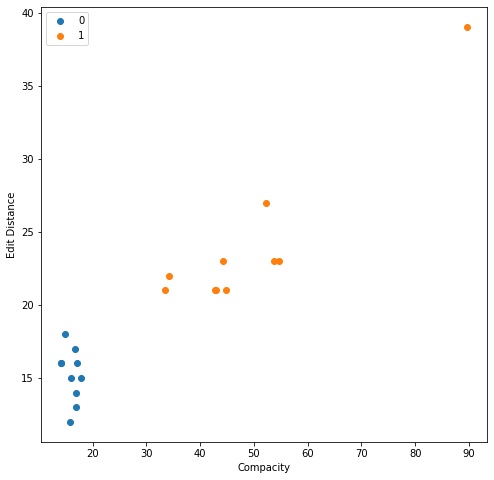

In [10]:
# compute edit distance for 0 and 1
zeros_distance = edit_distance(zeros_im, zeros_im[1], compacity)
ones_distance = edit_distance(ones_im, ones_im[1], compacity)

# visualize
plt.figure(figsize=(8,8))
plt.scatter(zeros_distance[:,0], zeros_distance[:,1], label='0')
plt.scatter(ones_distance[:,0], ones_distance[:,1],  label='1')
plt.ylabel('Edit Distance')
plt.xlabel('Compacity')
plt.legend()
plt.show()

Based on our result, we could successfully classify the images of class 0 and 1. Additionally, we find out that the distribution of the cluster 0 is much condensed while the one of cluster 1 is more widespread, which reflects larger in-cluster variance.

#### Method 3: Compacity and rectangularity (Region based)

In [11]:
def rectangularity(img):
    # compute rectangularity to the given image
    contour, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(contour[0])
    x, y, w, h = cv2.boundingRect(contour[0])
    rect_area = w * h
    return float(area)/rect_area


def extract_feature(img, func1, func2):
    # extract features of the given image using function 1 and function 2
    img_rotated = img_rotate(img)
    features = []
    for i in img_rotated:
        a1, a2 = func1(i), func2(i)
        features.append([a1, a2])
    features = np.array(features)
    return features, [func1.__name__, func2.__name__]


def plot_feature(img_featured, features, labels):
    plt.figure(figsize=(10, 6))
    for f, l in zip(img_featured, labels):
        plt.scatter(f[:,0], f[:,1], label = l)
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()

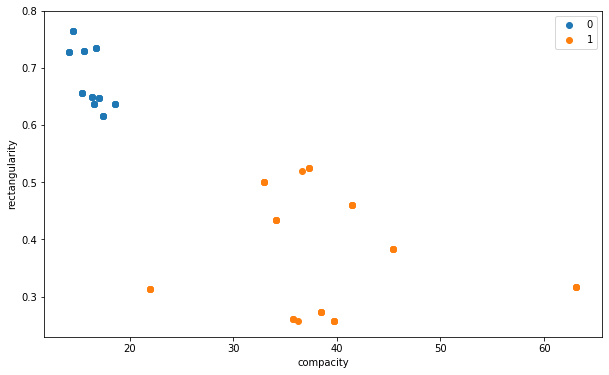

In [12]:
# augment two sets of images
img_augment = [zeros_im, ones_im]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, compacity, rectangularity)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

TODO...

#### Method 4: Elongation and compacity (Region based)

In [13]:
def elongation(img):
    img = ndimage.grey_opening(img,size = (2,2))
    _, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    m = cv2.moments(thresh)
    x = m['mu20'] + m['mu02']
    y = 4 * m['mu11']**2 + (m['mu20'] - m['mu02'])**2
    return (x + y**0.5) / (x - y**0.5)

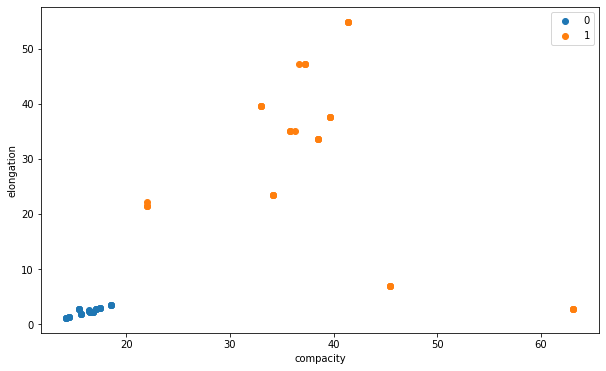

In [14]:
# augment two sets of images
img_augment = [zeros_im, ones_im]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, compacity, elongation)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

TODO...

#### Method 5: Elongation and rectangularity (Region based)

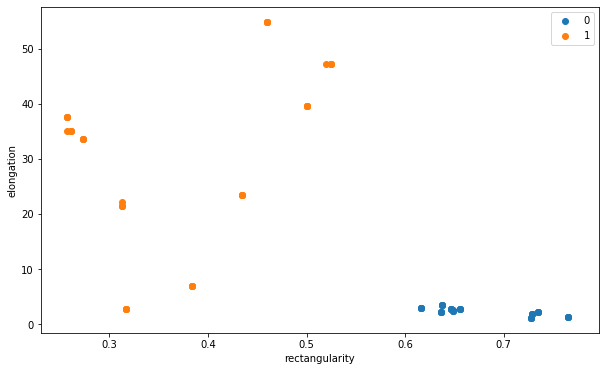

In [15]:
# augment two sets of images
img_augment = [zeros_im, ones_im]

imgs_f = []
for img in img_augment:
    img_f, f_name = extract_feature(img, rectangularity, elongation)
    imgs_f.append(img_f)

plot_feature(imgs_f, f_name, range(len(img_augment)))

TODO...

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

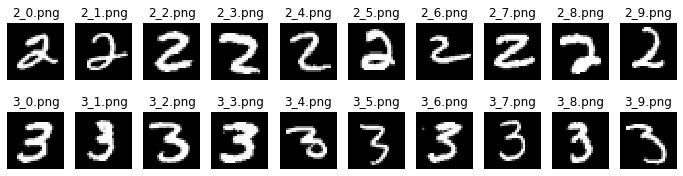

In [16]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptor

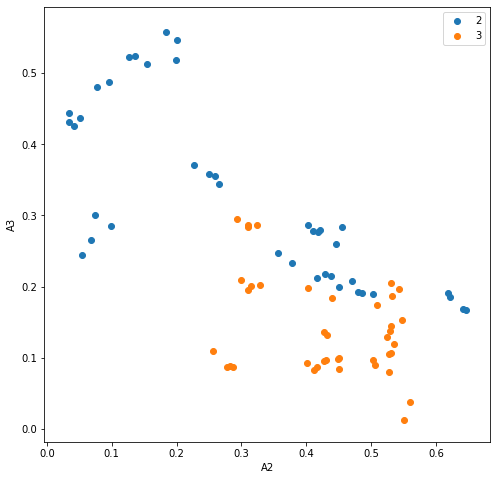

In [17]:
twos_fourier = fourier_trans(twos_im, [2,3])
threes_fourier = fourier_trans(threes_im, [2,3])

plt.figure(figsize=(8,8))
plt.scatter(twos_fourier[:,0], twos_fourier[:,1], label='2')
plt.scatter(threes_fourier[:,0], threes_fourier[:,1], label='3')
plt.ylabel('A3')
plt.xlabel('A2')
plt.legend()
plt.show()

TODO...

### 2.3 Additional method(s) and conclusion
Add your implementations and discussions here

#### Method 1: Distance map using Chamfer distance (Contour based)
We apply the same method as we did in the part 1.

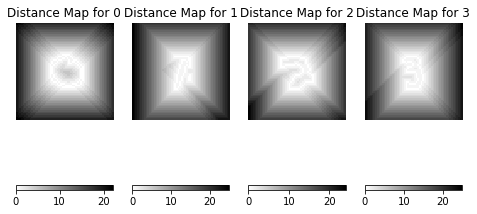

In [18]:
# distance map for 0, 1, 2, 3
distance_map_zero = distance_map(zeros_im[8, :, :])
distance_map_one = distance_map(ones_im[8,:,:])
distance_map_two = distance_map(twos_im[8, :, :])
distance_map_three = distance_map(threes_im[8,:,:])



# visualize
plt.figure(figsize = (16, 8))
plt.subplot(1, 4, 1)
plt.imshow(distance_map_zero, cmap = 'binary')
plt.title('Distance Map for 0')
plt.colorbar(orientation='horizontal')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(distance_map_one, cmap = 'binary')
plt.title('Distance Map for 1')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.subplot(1, 4, 3)
plt.imshow(distance_map_two, cmap = 'binary')
plt.title('Distance Map for 2')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.subplot(1, 4, 4)
plt.imshow(distance_map_three, cmap = 'binary')
plt.title('Distance Map for 3')
plt.axis('off')
plt.colorbar(orientation='horizontal')
plt.show()

In [21]:
features2 = pd.DataFrame(index = np.arange(0, len(twos_im)+len(threes_im)), columns = ['Feature 0','Feature 1'])
image = np.ones((twos_im[8, :, :].shape[0], twos_im[8, :, :].shape[1]))

# all zero images:
for m in range(len(twos_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv2.findContours(twos_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton = cv2.drawContours(image-1, contour, -1, (255, 255, 255), 1)
    skeleton = np.where(skeleton == 255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(2) For Feature 0 on image2_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_two, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], m)
    features2.iloc[m, 0] = min_distance
    print('\n(3) For Feature 1 on image2_{}'.format(m))
    min_distance = find_optimal_trans(distance_map_three, shift_x, shift_y, skeleton[minr:maxr, minc:maxc], m)
    features2.iloc[m, 1] = min_distance
    image = np.ones((twos_im[8, :, :].shape[0], twos_im[8, :, :].shape[1]))
    

# all one images
image = np.ones((threes_im[8, :, :].shape[0], threes_im[8, :, :].shape[1]))
for n in range(len(threes_im)):
    #find the contour of the image and threhsolding the contour
    contour, _ = cv2.findContours(threes_im[n,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton = cv2.drawContours(image-1, contour, -1, (255,255,255), 1)
    skeleton = np.where(skeleton==255, 1, 0)
    
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
        
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    print('\n(3) For Feautre 0 on image3_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_two, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features2.iloc[m+n+1, 0] = min_distance
    print('\n(3) For Feature 1 on image3_{}'.format(n))
    min_distance = find_optimal_trans(distance_map_three, shift_x, shift_y, skeleton[minr:maxr,minc:maxc], n)
    features2.iloc[m+n+1, 1] = min_distance
    image=np.ones((threes_im[8, :, :].shape[0], threes_im[8, :, :].shape[1]))


(2) For Feature 0 on image2_0
Angle:270 and translation:[20,21] => min_distance:84

(3) For Feature 1 on image2_0
Angle:270 and translation:[20,21] => min_distance:100

(2) For Feature 0 on image2_1
Angle:270 and translation:[19,19] => min_distance:93

(3) For Feature 1 on image2_1
Angle:0 and translation:[23,21] => min_distance:115

(2) For Feature 0 on image2_2
Angle:180 and translation:[20,18] => min_distance:108

(3) For Feature 1 on image2_2
Angle:180 and translation:[20,18] => min_distance:125

(2) For Feature 0 on image2_3
Angle:0 and translation:[20,18] => min_distance:77

(3) For Feature 1 on image2_3
Angle:180 and translation:[20,20] => min_distance:119

(2) For Feature 0 on image2_4
Angle:180 and translation:[20,19] => min_distance:71

(3) For Feature 1 on image2_4
Angle:180 and translation:[20,18] => min_distance:80

(2) For Feature 0 on image2_5
Angle:0 and translation:[20,21] => min_distance:89

(3) For Feature 1 on image2_5
Angle:0 and translation:[20,20] => min_distanc

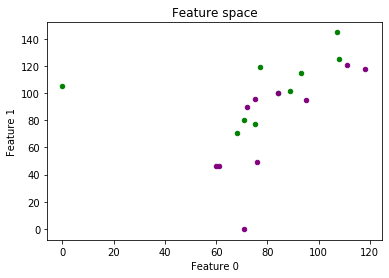

In [22]:
ax = features2.iloc[0:len(twos_im), :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Green')
features2.iloc[len(twos_im)::, :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Purple', ax = ax)
plt.title('Feature space')
plt.show()

Sadly, we could not perform well for the classification between class 2 and 3. The clusters are mixed together.

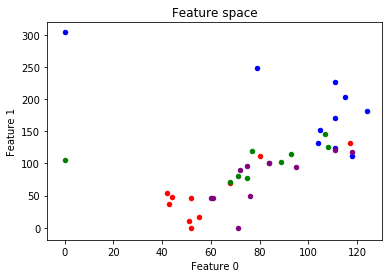

In [23]:
# all digits
ax = features.iloc[0:len(zeros_im), :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Blue')
features.iloc[len(zeros_im)::, :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Red', ax = ax)
features2.iloc[0:len(twos_im), :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Green', ax = ax)
features2.iloc[len(twos_im)::, :].plot.scatter(x = 'Feature 0', y = 'Feature 1', c = 'Purple', ax = ax)
plt.title('Feature space')
plt.show()

Considering all 4 digits, we see that we are unable to classify them because the clusters of each digit are aligned together.

#### Method 2: Chain code using edition distance (Contour based)

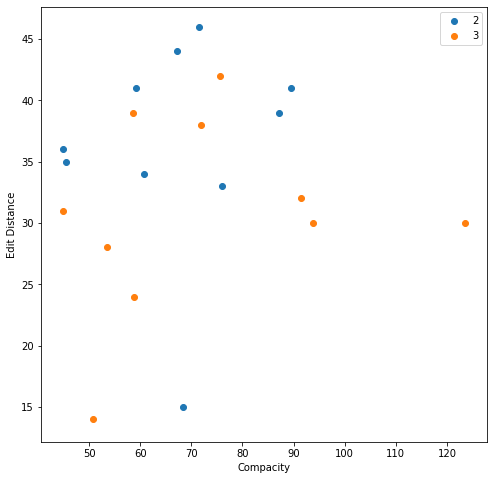

In [24]:
# compute edit distance for 2 and 3
twos_distance = edit_distance(twos_im, twos_im[1], compacity)
threes_distance = edit_distance(threes_im, threes_im[1], compacity)

# visualize
plt.figure(figsize=(8,8))
plt.scatter(twos_distance[:, 0], twos_distance[:, 1], label='2')
plt.scatter(threes_distance[:, 0], threes_distance[:, 1],  label='3')
plt.ylabel('Edit Distance')
plt.xlabel('Compacity')
plt.legend()
plt.show()

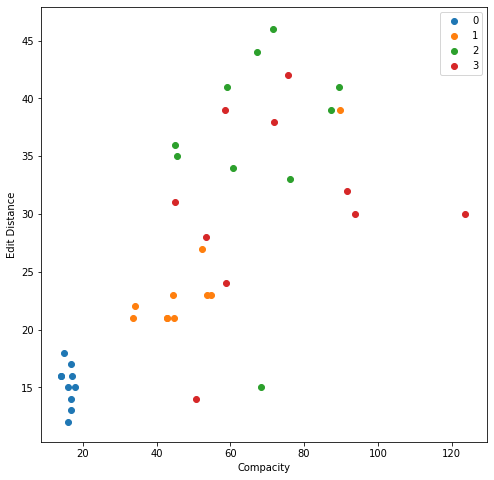

In [25]:
# visualize in the case for all digits
plt.figure(figsize=(8,8))
plt.scatter(zeros_distance[:, 0], zeros_distance[:, 1], label='0')
plt.scatter(ones_distance[:, 0], ones_distance[:, 1],  label='1')
plt.scatter(twos_distance[:, 0], twos_distance[:, 1], label='2')
plt.scatter(threes_distance[:, 0], threes_distance[:, 1],  label='3')
plt.ylabel('Edit Distance')
plt.xlabel('Compacity')
plt.legend()
plt.show()

We could classify the cluster of digit 0. However, for the other digits, we could not because their clusters are mixed together.